# **Zero-Loss Peak Subtraction with Neural Networks**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/CBL-ML/blob/tutorial/Tutorial/EELS_tutorial.ipynb)

## Loading the data

First of all, let us install and import all the required modules

In [1]:
!pip install ncempy
#!wget https://github.com/LHCfitNikhef/CBL-ML/raw/tutorial/Tutorial/area03-eels-SI-aligned.dm4
#!wget https://raw.githubusercontent.com/LHCfitNikhef/CBL-ML/tutorial/Tutorial/imageClass.py
#!wget https://raw.githubusercontent.com/LHCfitNikhef/CBL-ML/tutorial/Tutorial/trainZLP.py

In [2]:
from ncempy.io import dm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


import imageClass as EELSImage
import trainZLP as ZLPnn
#from trainZLP import train_nn_scaled

In this tutorial, we will study.....

The spectral image can be imported with the lines below

In [3]:
path_to_dm4 = 'area03-eels-SI-aligned.dm4'
im = EELSImage.Spectral_image.load_data(path_to_dm4)

## Plotting the data

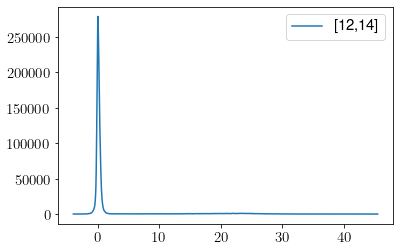

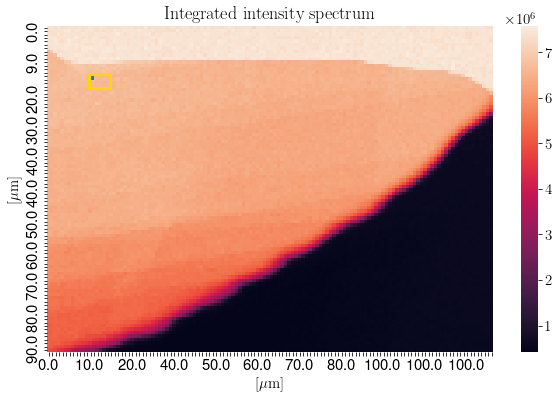

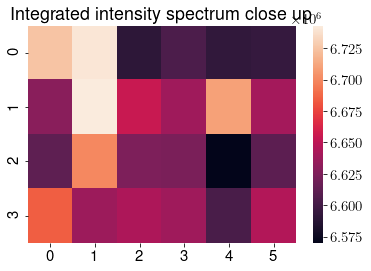

In [4]:
full_width, full_height = im.image_shape[1], im.image_shape[0]
loc_x, loc_y = int(0.1 * full_width), int(0.15 * full_height)
spectrum = im.plot_spectrum(loc_y, loc_x)

xmin, width = int(0.1 * full_width), int(0.05 * full_width)
ymin, height = int(0.15 * full_height), int(0.05 * full_height)

window = np.array([[xmin, width], [ymin, height]])
im.show_image(selection = window, pixel_highlight = [loc_x, loc_y])

## Smoothing

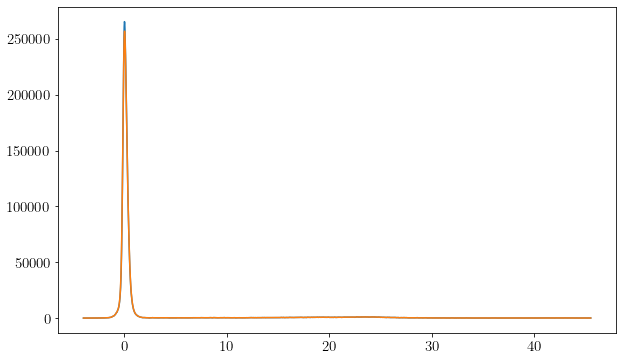

In [5]:
data_zoomed_concat = np.reshape(im.data_zoomed, (-1, im.l))
data_smooth = ZLPnn.smooth(data_zoomed_concat, window_len = 10)

plt.figure(figsize=(10,6))
plt.plot(im.deltaE, im.data_zoomed[-1, -2, :])
plt.plot(im.deltaE, data_smooth[-2,:])
plt.show()

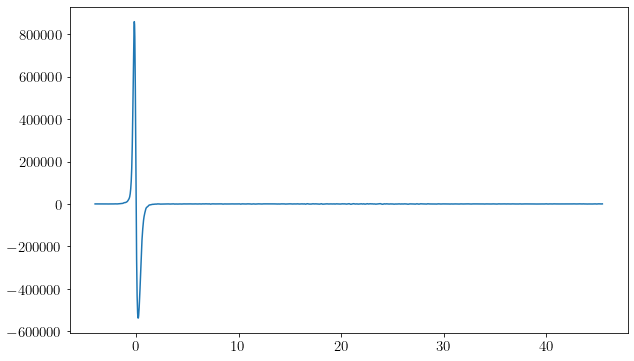

In [6]:
def der_spect(image, spectrum):
    dx = image.ddeltaE
    der_spectrum = (spectrum[:,1:]-spectrum[:,:-1])/dx
    return der_spectrum

der = der_spect(im, data_smooth)
der_smooth = ZLPnn.smooth(der, window_len = 10)

plt.figure(figsize=(10,6))
plt.plot(im.deltaE[:-1], der_smooth[-1,:])
plt.show()

## Finding $dE_1$ and $dE_2$

In [7]:
data_avg = np.average(data_smooth, axis=0)
der_avg = np.average(der, axis=0)

dE1 = ZLPnn.find_dE1(im, der_avg, data_avg, fct=0.7)

times_dE1 = 3
min_dE2 = im.deltaE.max() - im.ddeltaE*im.l*0.05 # discuss with Isabel
dE2 = np.minimum(dE1 * times_dE1, min_dE2) 

In [8]:
select1 = len(im.deltaE[im.deltaE<dE1]) # discuss with Isabel: not symmetric
select2 = len(im.deltaE[im.deltaE>dE2])

#discuss with Isabel
# pseudo_x = np.ones(select1 + select2)
# pseudo_x[:select1] = deltaE_scaled[:select1]
# pseudo_x[-select2:] = deltaE_scaled[-select2:]

## Rescaling the training data

In [9]:
def rescale(data, mean, std):
    return (data - mean) / std

deltaE_scaled = rescale(im.deltaE[:select1], np.mean(im.deltaE[:select1]), np.std(im.deltaE[:select1]))


# def find_scale_param(inp, min_out = 0.1, max_out=0.9):
#     a = (max_out - min_out)/(inp.max()- inp.min())
#     b = min_out - a * inp.min()
#     return [a, b]

# def scale(inp, ab):
#     return inp * ab[0] + ab[1]


# ab_deltaE = find_scale_param(im.deltaE)
# deltaE_scaled = scale(im.deltaE, ab_deltaE)


epsilon = 1e-3
data_zoomed_concat[data_zoomed_concat < 0] = epsilon

ci_low = np.nanpercentile(np.log(data_zoomed_concat), 16, axis=0)
ci_high = np.nanpercentile(np.log(data_zoomed_concat), 84, axis=0)
sigma = np.absolute(ci_high - ci_low)

Discuss with Isabel: rescale before or after applying dE cuts?

## Constructing the Neural Network

2021-06-01 20:42:48.641331 Replica 0, Epoch 1, Training loss 49847.05332955259, Validation loss 96781.66260845058
2021-06-01 20:42:49.096462 Replica 0, Epoch 500, Training loss 848.3992766738792, Validation loss 1089.245483966913
2021-06-01 20:42:49.541012 Replica 0, Epoch 1000, Training loss 603.8839431248645, Validation loss 718.2795756933541
2021-06-01 20:42:49.958867 Replica 0, Epoch 1500, Training loss 575.1524030185142, Validation loss 569.1736675741992
2021-06-01 20:42:50.374590 Replica 0, Epoch 2000, Training loss 0.559660384566501, Validation loss 2.686002139076721
2021-06-01 20:42:50.788687 Replica 0, Epoch 2500, Training loss 0.3992100936519243, Validation loss 1.5772276960309033
2021-06-01 20:42:51.201015 Replica 0, Epoch 3000, Training loss 0.32562416812113554, Validation loss 0.8266230400105185
2021-06-01 20:42:51.622082 Replica 0, Epoch 3500, Training loss 0.2811311921662453, Validation loss 0.4761195522297111
2021-06-01 20:42:52.042707 Replica 0, Epoch 4000, Training lo

2021-06-01 20:43:15.606331 Replica 7, Epoch 3000, Training loss 0.08857946472536385, Validation loss 0.9428267024743751
2021-06-01 20:43:16.094280 Replica 7, Epoch 3500, Training loss 0.0868883792012585, Validation loss 0.9480593484691006
2021-06-01 20:43:16.530712 Replica 7, Epoch 4000, Training loss 0.08577855014215827, Validation loss 0.9696723279750974
2021-06-01 20:43:16.533587 Replica 8, Epoch 1, Training loss 0.7958386774879799, Validation loss 2.355161549831424
2021-06-01 20:43:16.978016 Replica 8, Epoch 500, Training loss 0.1545619088695689, Validation loss 0.7069555606636307
2021-06-01 20:43:17.458780 Replica 8, Epoch 1000, Training loss 0.11985289741822142, Validation loss 0.47539165663684146
2021-06-01 20:43:17.924077 Replica 8, Epoch 1500, Training loss 0.1245424748036303, Validation loss 0.4794685757974667
2021-06-01 20:43:18.350764 Replica 8, Epoch 2000, Training loss 0.16095463540391267, Validation loss 0.6269377705406732
2021-06-01 20:43:18.827156 Replica 8, Epoch 2500

2021-06-01 20:43:43.947046 Replica 15, Epoch 1500, Training loss 0.23560764708882403, Validation loss 0.5155531937189032
2021-06-01 20:43:44.375348 Replica 15, Epoch 2000, Training loss 0.2444512524595672, Validation loss 0.48912618273374187
2021-06-01 20:43:44.849016 Replica 15, Epoch 2500, Training loss 0.2506625754940164, Validation loss 0.49409451042846214
2021-06-01 20:43:45.321700 Replica 15, Epoch 3000, Training loss 0.21574912482921307, Validation loss 0.4536363789790171
2021-06-01 20:43:45.816304 Replica 15, Epoch 3500, Training loss 0.20895254639026814, Validation loss 0.44542700309121774
2021-06-01 20:43:46.285510 Replica 15, Epoch 4000, Training loss 0.2824043810384932, Validation loss 0.5809257656754865
2021-06-01 20:43:46.288694 Replica 16, Epoch 1, Training loss 3.537953509490975, Validation loss 0.8136138903066775
2021-06-01 20:43:46.775170 Replica 16, Epoch 500, Training loss 2.6211986055308047, Validation loss 0.4768394625600841
2021-06-01 20:43:47.258513 Replica 16, 

2021-06-01 20:44:12.074640 Replica 23, Epoch 500, Training loss 0.1908058299226836, Validation loss 0.1903860147810809
2021-06-01 20:44:12.504517 Replica 23, Epoch 1000, Training loss 0.18637194999567577, Validation loss 0.1873026784855259
2021-06-01 20:44:12.936952 Replica 23, Epoch 1500, Training loss 0.3561013477618087, Validation loss 0.2800880917970264
2021-06-01 20:44:13.367828 Replica 23, Epoch 2000, Training loss 0.18034604301513008, Validation loss 0.18259829443928238
2021-06-01 20:44:13.802082 Replica 23, Epoch 2500, Training loss 0.1780444584767435, Validation loss 0.17975271275087204
2021-06-01 20:44:14.265541 Replica 23, Epoch 3000, Training loss 0.17524348252171162, Validation loss 0.17967361947337776
2021-06-01 20:44:14.710472 Replica 23, Epoch 3500, Training loss 0.19498455903257875, Validation loss 0.19277942197523987
2021-06-01 20:44:15.143159 Replica 23, Epoch 4000, Training loss 0.1760263671981799, Validation loss 0.18376125567929838


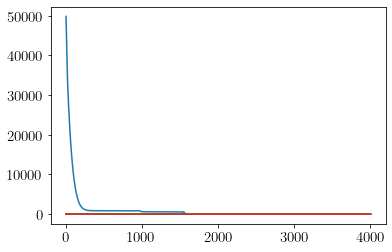

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime

class MLP(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 10)
        self.linear2 = nn.Linear(10, 15)
        self.linear3 = nn.Linear(15, 5)
        self.output = nn.Linear(5, num_outputs)
        self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        x = self.tanh(x)
        x = self.linear3(x)
        x = self.tanh(x)
        x = self.output(x)
        return x
    
def loss_fn(output, target, error):
    loss = torch.mean(torch.square((output - target)/error))
    return loss

# def weight_reset(m):
#     if isinstance(m, nn.Linear):
#         m.reset_parameters()
        
        
def weights_init(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def training_loop(n_rep, n_epochs, optimizer, model, loss_fn):
    
    data_x = deltaE_scaled[:select1]
    data_sigma = im.data_unc[:select1]
    
    for rep in range(n_rep):
        
        #model.apply(weights_init)
        
        data_y = np.log(data_zoomed_concat[rep][:select1])
       
        train_x, test_x, train_y, test_y, train_sigma, test_sigma = train_test_split(data_x, data_y, data_sigma, test_size=0.5)

        train_x = torch.tensor(train_x).unsqueeze(-1) 
        test_x = torch.tensor(test_x).unsqueeze(-1) 
        
        train_y = torch.tensor(train_y).unsqueeze(-1)
        test_y = torch.tensor(test_y).unsqueeze(-1)
        
        train_sigma = torch.tensor(train_sigma).unsqueeze(-1)
        test_sigma = torch.tensor(test_sigma).unsqueeze(-1)
        
        validation_loss = []
        training_loss = []
        loss_val_old = 0
        overfit_counter = 0
        patience = 1000
        for epoch in range(1, n_epochs + 1):
            
            loss_train = 0.0
            loss_val = 0.0
            
            model_output = model(train_x.float())
            
            loss = loss_fn(model_output, train_y, train_sigma)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()
            training_loss.append(loss_train)
        
            #validation loss
            
            with torch.no_grad():
                model_output = model(test_x.float())
                val_loss = loss_fn(model_output, test_y, test_sigma)
                loss_val += val_loss.item()
                validation_loss.append(loss_val)
                assert val_loss.requires_grad == False

#             model.eval()
#             with torch.no_grad():
#                 loss_val = 0.0
#                 model_output = model(test_x.float())
#                 loss = loss_fn(model_output, test_y, test_sigma)
                
#                 #assert loss_val.requires_grad is False
#                 loss_val += loss.item()
#                 validation_loss.append(loss_val)
             
#             if loss_val > loss_val_old and epoch > 1:
#                 overfit_counter += 1
                
#             if overfit_counter == patience:
#                 torch.save(model.state_dict(), './models/trained_nn_rep_{}.pt'.format(rep))
#                 print(loss_train, epoch)
#                 break
                
#             loss_val_old = loss_val
            
            if epoch == 1 or epoch % 500 == 0:
                print('{} Replica {}, Epoch {}, Training loss {}, Validation loss {}'.format(datetime.datetime.now(), rep, epoch, loss_train, loss_val))
        
        #print(validation_loss)
        torch.save(model.state_dict(), './models/trained_nn_rep_{}.pt'.format(rep))
        plt.plot(training_loss)

n_rep = im.data_zoomed.shape[0] * im.data_zoomed.shape[1]
n_epochs = 4000
model = MLP(num_inputs=1, num_outputs=1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)                
                
training_loop(
    n_rep = n_rep,
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn
)

Play with different optimizers/architectures/learning rates

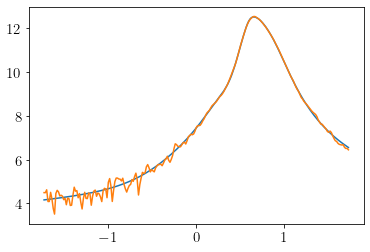

In [15]:
network_path = './models/trained_nn_rep_0.pt'
model.load_state_dict(torch.load(network_path))

data_x = deltaE_scaled[:select1]
data_x = torch.tensor(data_x).unsqueeze(-1)

model_pred = model.forward(data_x.float())
model_pred = model_pred.detach().numpy()

plt.plot(deltaE_scaled[:select1], model_pred)
plt.plot(deltaE_scaled[:select1], np.log(im.data_zoomed_concat[0][:select1]))
plt.show()

## Training report

Plot of loss
validation set
adding dE2


## Evaluating the trained models

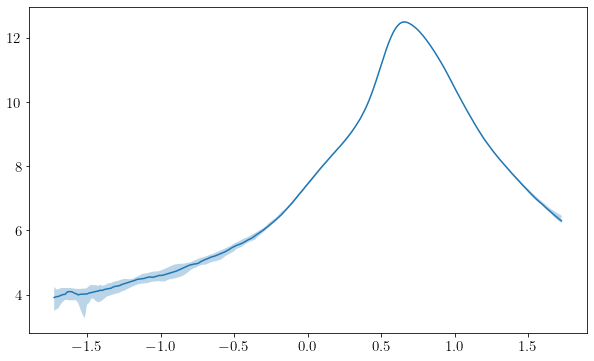

In [16]:
pred = []

for rep in range(0,n_rep):
    network_path = './models/trained_nn_rep_{}.pt'.format(rep)
    model.load_state_dict(torch.load(network_path))
    
    model_pred = model.forward(data_x.float())
    model_pred = model_pred.detach().numpy()
    pred.append(model_pred[:,0])

pred = np.array(pred)
pred_median = np.median(pred, axis=0)
cl_low = np.nanpercentile(pred, 16, axis=0)
cl_high = np.nanpercentile(pred, 84, axis=0)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
plt.plot(deltaE_scaled[:select1], pred_median)
ax.fill_between(deltaE_scaled[:select1], cl_low, cl_high, alpha = 0.3)
plt.show()

Discuss with Isabel: pretrained models

## ZLP subtraction

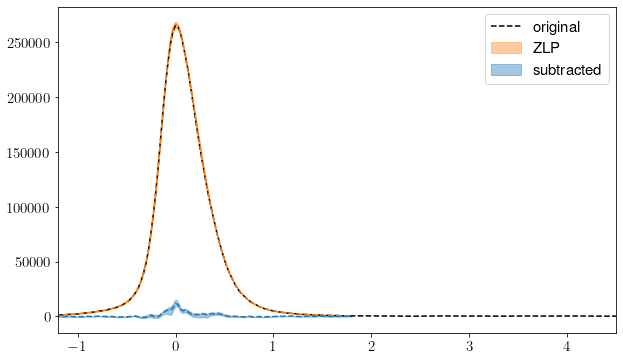

In [17]:
plt.figure(figsize=(10,6))
plt.plot(im.deltaE, data_zoomed_concat[-2], linestyle='dashed', label='original', color='k')
plt.fill_between(im.deltaE[:select1], np.exp(cl_low), np.exp(cl_high), alpha = 0.4, label='ZLP', color='C1')
plt.plot(im.deltaE[:select1], np.exp(pred_median), linestyle = 'dashed', color='C1')
plt.plot(im.deltaE[:select1], data_zoomed_concat[0][:select1]-np.exp(pred_median), linestyle='dashed')
plt.fill_between(im.deltaE[:select1], data_zoomed_concat[0][:select1] - np.exp(cl_low), data_zoomed_concat[0][:select1] - np.exp(cl_high), alpha = 0.4, label='subtracted', color='C0')
plt.xlim(-1.2, 4.5)
plt.legend()
plt.show()

## Bandgap fit